In [4]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [6]:
movie_reviews = pd.read_csv('IMDB-Dataset.csv')
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

<AxesSubplot: xlabel='sentiment', ylabel='count'>

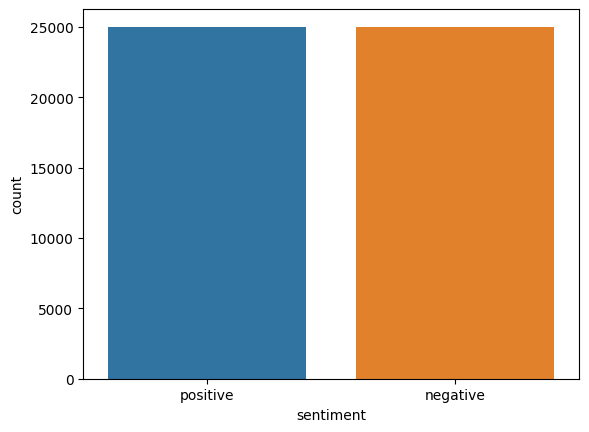

In [9]:
import seaborn as s
s.countplot(x='sentiment', data=movie_reviews)

In [17]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tages(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    sentence = remove_tages(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [18]:
review = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    review.append(preprocess_text(sen))

In [20]:
converted = movie_reviews['sentiment']
converted = np.array(list(map(lambda x: 1 if x=="positive" else 0, converted)))

In [21]:
review_train, review_test, converted_train, converted_test = train_test_split(review, converted, test_size=0.20, random_state=42)

In [22]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)

review_train = tokenizer.texts_to_sequences(review_train)
review_test = tokenizer.texts_to_sequences(review_test)

In [23]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

review_train = pad_sequences(review_train, padding='post', maxlen=maxlen)
review_test = pad_sequences(review_test, padding='post', maxlen=maxlen)

In [24]:
from numpy import array
from numpy import asarray
from numpy import zeros

embedding_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embedding_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [27]:
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________


In [28]:
history = model.fit(review_train, converted_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model.evaluate(review_test, converted_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 42s 155ms/step - loss: 0.5495 - acc: 0.7136 - val_loss: 0.4540 - val_acc: 0.7954
Epoch 2/6
250/250 [==============================] - 35s 141ms/step - loss: 0.4495 - acc: 0.7894 - val_loss: 0.4126 - val_acc: 0.8130
Epoch 3/6
250/250 [==============================] - 33s 132ms/step - loss: 0.4100 - acc: 0.8120 - val_loss: 0.4013 - val_acc: 0.8106
Epoch 4/6
250/250 [==============================] - 33s 131ms/step - loss: 0.3780 - acc: 0.8300 - val_loss: 0.3578 - val_acc: 0.8440
Epoch 5/6
250/250 [==============================] - 33s 132ms/step - loss: 0.3503 - acc: 0.8449 - val_loss: 0.3458 - val_acc: 0.8506
Epoch 6/6
313/313 [==============================] - 8s 25ms/step - loss: 0.3450 - acc: 0.8419


In [29]:
print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

Test Score:  0.3450270891189575
Test Accuracy:  0.8418999910354614


In [30]:
instance = review[60]
print(instance)

What happened What we have here is basically solid and plausible premise and with decent and talented cast but somewhere the movie loses it Actually it never really got going There was little excitement when we find out that Angie is not really pregnant then find out that she is after all but that was it Steve Martin who is very talented person and usually brings lot to movie was dreadful and his entire character was not even close to being important to this movie other than to make it longer really would have liked to see more interactions between the main characters Kate and Angie and maybe try not for pure comedy which unfortunately it was not but maybe drama with comedic elements think if the movie did this it could have been very funny since both actresses are quite funny in their own ways and sitting here can think of numerous scenarios that would have been riot 


In [31]:
instance = tokenizer.texts_to_sequences(instance)
flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
model.predict(instance)

1/1 [==============================] - 0s 422ms/step


array([[0.32976088]], dtype=float32)

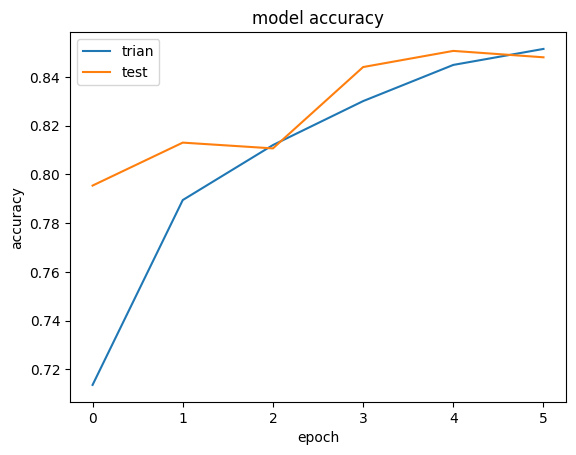

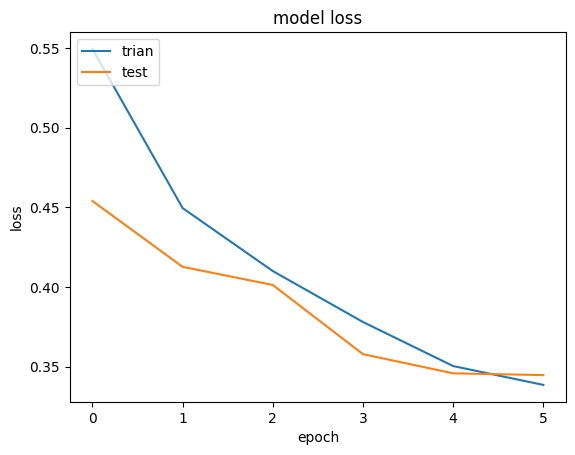

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['trian', 'test'], loc= 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['trian', 'test'], loc= 'upper left')
plt.show()